In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore")

2024-12-10 22:59:00.082439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tickers = ['JPM', 'NVDA']

for ticker in tickers:
    stock_data = yf.download(ticker, start='2018-12-31', end='2022-12-31')
    
    prices = np.array(stock_data.reset_index()['Close'])
    prices_diff = prices[1:] - prices[:-1]
    prices_log = np.log(prices)
    prices_log_diff = prices_log[1:] - prices_log[:-1]
    
    df = pd.DataFrame({
        'prices': prices,
        'prices_diff': np.append([np.nan], prices_diff), 
        'prices_log': prices_log,
        'prices_log_diff': np.append([np.nan], prices_log_diff)  
    })
    
    globals()[f'{ticker}'] = df
    

print(JPM.head())
print(NVDA.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

       prices  prices_diff  prices_log  prices_log_diff
0   97.620003          NaN    4.581082              NaN
1   99.309998     1.689995    4.598246         0.017164
2   97.110001    -2.199997    4.575844        -0.022402
3  100.690002     3.580002    4.612047         0.036202
4  100.760002     0.070000    4.612741         0.000695
    prices  prices_diff  prices_log  prices_log_diff
0  3.33750          NaN    1.205222              NaN
1  3.40550      0.06800    1.225392         0.020170
2  3.19975     -0.20575    1.163073        -0.062319
3  3.40475      0.20500    1.225172         0.062099
4  3.58500      0.18025    1.276758         0.051587


In [3]:
for ticker in tickers:
    stock_data = yf.download(ticker, start='2022-12-31', end='2023-12-31')
    
    prices = np.array(stock_data.reset_index()['Close'])
    prices_diff = prices[1:] - prices[:-1]
    prices_log = np.log(prices)
    prices_log_diff = prices_log[1:] - prices_log[:-1]
    
    df = pd.DataFrame({
        'prices': prices,
        'prices_diff': np.append([np.nan], prices_diff), 
        'prices_log': prices_log,
        'prices_log_diff': np.append([np.nan], prices_log_diff)  
    })
    
    globals()[f'{ticker}_test'] = df

print(JPM_test.head())
print(NVDA_test.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

       prices  prices_diff  prices_log  prices_log_diff
0  135.119995          NaN    4.906163              NaN
1  136.380005     1.260010    4.915445         0.009282
2  135.350006    -1.029999    4.907864        -0.007581
3  137.940002     2.589996    4.926819         0.018955
4  137.369995    -0.570007    4.922678        -0.004141
   prices  prices_diff  prices_log  prices_log_diff
0  14.315          NaN    2.661308              NaN
1  14.749     0.434000    2.691175         0.029867
2  14.265    -0.483999    2.657809        -0.033366
3  14.859     0.594000    2.698606         0.040797
4  15.628     0.769000    2.749064         0.050458


In [4]:
NVDA_df = pd.concat([NVDA, NVDA_test], axis=0, ignore_index=True)
data = NVDA_df.filter(['prices'])
data

,prices
0,3.337500
1,3.405500
2,3.199750
3,3.404750
4,3.585000
...,...
1254,48.830002
1255,49.278999
1256,49.417000
1257,49.521999


In [5]:
dataset = data.values

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
traindata = dataset[0:1009, :]
train_data = scaler.fit_transform(traindata)

x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 11:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00456485, 0.00681828, 0.        , 0.00679343, 0.01276667,
       0.00980904, 0.01208733, 0.01428276, 0.01726524, 0.01859906])]
[0.018126844082459667]

[array([0.00456485, 0.00681828, 0.        , 0.00679343, 0.01276667,
       0.00980904, 0.01208733, 0.01428276, 0.01726524, 0.01859906]), array([0.00681828, 0.        , 0.00679343, 0.01276667, 0.00980904,
       0.01208733, 0.01428276, 0.01726524, 0.01859906, 0.01812684])]
[0.018126844082459667, 0.017273518681176922]



In [7]:
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(x_train.shape[1], 1), kernel_regularizer=l2(l2=0.01)))
# model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    x_train, 
    y_train, 
    batch_size=16, 
    epochs=100, 
    validation_split=0.2
)
model.save('NVDA_GRU.keras')

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0386 - val_loss: 0.0099
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

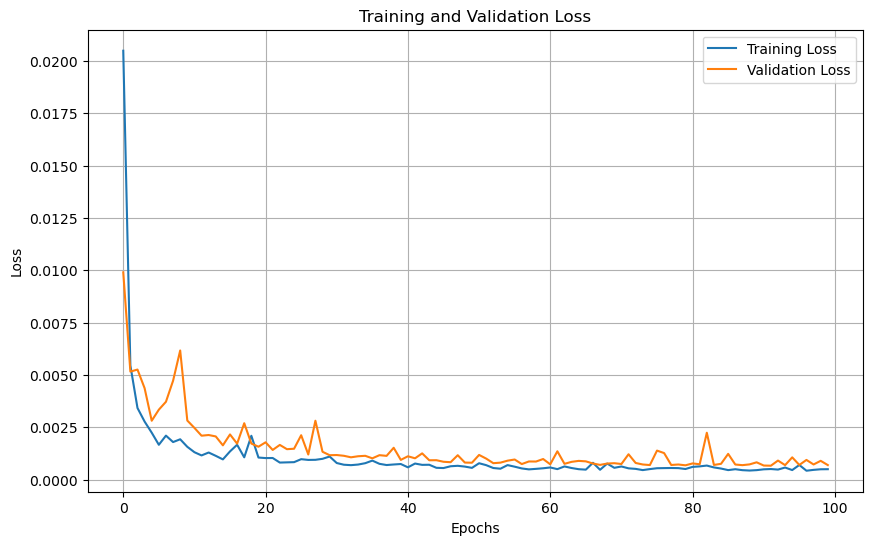

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
testdata = dataset[1009 - 10: , :]
test_data = scaler.transform(testdata)

x_test = []
y_test = dataset[1009:, :]

for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


1.0930318804932204

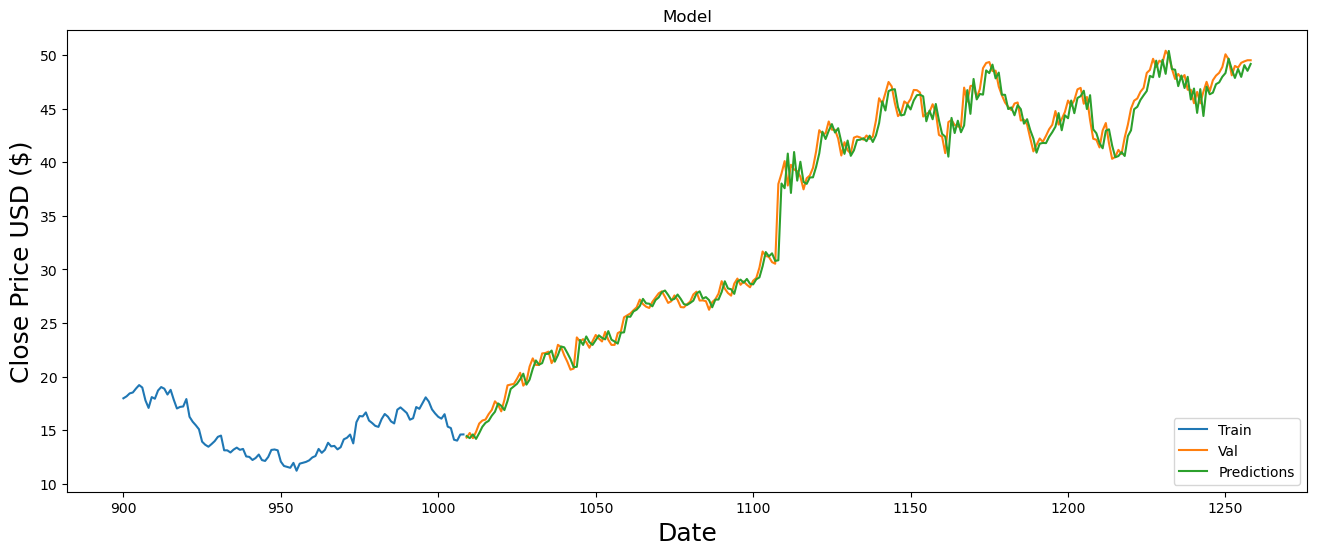

In [10]:
train = data[:1009]
valid = data[1009:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['prices'][900:])
plt.plot(valid[['prices', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()